In [1]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
import yfinance as yf

import cvxpy as cp

In [2]:
# Load the GICS sector information from the CSV file
df = pd.read_csv("data/sp500_gics_sectors.csv", index_col=0)
information_technology_stocks = list(df[df["GICS Sector"] == "Information Technology"].index)
healthcare_stocks = list(df[df["GICS Sector"] == "Health Care"].index)
financials_stocks = list(df[df["GICS Sector"] == "Financials"].index)
consumer_discretionary_stocks = list(df[df["GICS Sector"] == "Consumer Discretionary"].index)
industrials_stocks = list(df[df["GICS Sector"] == "Industrials"].index)

print("Number of information technology stocks:", len(information_technology_stocks))
print("Number of healthcare stocks:", len(healthcare_stocks))
print("Number of financials stocks:", len(financials_stocks))
print("Number of consumer discretionary stocks:", len(consumer_discretionary_stocks))
print("Number of industrials stocks:", len(industrials_stocks))

Number of information technology stocks: 68
Number of healthcare stocks: 60
Number of financials stocks: 75
Number of consumer discretionary stocks: 50
Number of industrials stocks: 79


In [3]:
# load historical price data from file (originally scraped from Yahoo Finance)
DOWNLOAD_DATA = False
if DOWNLOAD_DATA:
    tickers = information_technology_stocks + healthcare_stocks + financials_stocks + \
          consumer_discretionary_stocks + industrials_stocks
    data = yf.download(tickers, start="2020-01-01", end="2025-01-01")
    # only store close prices
    data = data['Close']
    data.to_csv("data/sp500_prices.csv")
else:
    data = pd.read_csv("data/sp500_prices.csv", index_col=0, parse_dates=True)

data = data.dropna(axis=1, how='any')
returns = data.pct_change().dropna()



In [4]:
# remove sector indices of stocks with no data
information_technology_stocks = [stock for stock in information_technology_stocks if
                                 stock in returns.columns]
healthcare_stocks = [stock for stock in healthcare_stocks if stock in returns.columns]
financials_stocks = [stock for stock in financials_stocks if stock in returns.columns]
consumer_discretionary_stocks = [stock for stock in consumer_discretionary_stocks if 
                                 stock in returns.columns]
industrials_stocks = [stock for stock in industrials_stocks if stock in returns.columns]

print("Number of information technology stocks:", len(information_technology_stocks))
print("Number of healthcare stocks:", len(healthcare_stocks))
print("Number of financials stocks:", len(financials_stocks))
print("Number of consumer discretionary stocks:", len(consumer_discretionary_stocks))
print("Number of industrials stocks:", len(industrials_stocks))

# choose the stocks in the sectors 
returns = returns[information_technology_stocks + healthcare_stocks + financials_stocks + 
                   consumer_discretionary_stocks + industrials_stocks]

idxs_info_tech = [i for i, stock in enumerate(returns.columns) if stock in 
                  information_technology_stocks]
idxs_healthcare = [i for i, stock in enumerate(returns.columns) if stock in healthcare_stocks]
idxs_financials = [i for i, stock in enumerate(returns.columns) if stock in financials_stocks]
idxs_consumer_discretionary = [i for i, stock in enumerate(returns.columns) if stock in 
                               consumer_discretionary_stocks]
idxs_industrials = [i for i, stock in enumerate(returns.columns) if stock in industrials_stocks]

groups = [idxs_info_tech, idxs_healthcare, idxs_financials, idxs_consumer_discretionary, 
          idxs_industrials]

Number of information technology stocks: 66
Number of healthcare stocks: 58
Number of financials stocks: 72
Number of consumer discretionary stocks: 48
Number of industrials stocks: 75


In [5]:
# compute the covariance matrix and regularize it
Sigma = returns.cov().values
n = Sigma.shape[0]
alpha = 0.8
Sigma = alpha * Sigma + (1-alpha) * np.trace(Sigma) / n * np.eye(n)
evals = np.linalg.eigvalsh(Sigma)
print("smallest and largest eigenvalues of Sigma:", min(evals), max(evals))

# choose mean returns as mean predictor
mu = returns.mean().values

smallest and largest eigenvalues of Sigma: 0.0001224821758387878 0.06136787272333727


In [30]:
# specify risk contributions and regularization parameter
b = np.array([0.3, 0.25, 0.20, 0.15, 0.10])
lmbda = 1

In [33]:
# specify problem and solve
w = cp.Variable((n, ), nonneg=True)
t1 = cp.Variable((n, ))
t2 = cp.Variable()
obj = mu.T @ w - lmbda * t2
constraints = [cp.sum(w) == 1, t1 == Sigma @ w, t2 == cp.quad_form(w, Sigma)]

for k, g in enumerate(groups):
    constraints += [cp.abs(cp.sum(cp.multiply(w[g], t1[g])) - b[k] * t2) <= 0.1 * b[k] * t2]
    
w.value = np.ones(n) / n # uniform initial guess
problem = cp.Problem(cp.Maximize(obj), constraints)
problem.solve(solver=cp.IPOPT, nlp=True, verbose=True, derivative_test='none')

risk_contributions= w.value * (Sigma @ w.value) 
risk_contributions /= np.sum(risk_contributions)
risk_contributions = np.array([np.sum(risk_contributions[g]) for g in groups])

(CVXPY) Nov 12 10:40:28 AM: Your problem has 639 variables, 326 constraints, and 0 parameters.
(CVXPY) Nov 12 10:40:28 AM: It is compliant with the following grammars: 
(CVXPY) Nov 12 10:40:28 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 12 10:40:28 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 12 10:40:28 AM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                             v1.7.0.dev0+0.5870139                             
This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   103995
Number of nonzeros in inequality constraint Jacobian.:     1306
Number of nonzeros in Lagrangian Hessian.............:    51359

Total number of variables............................:     1282
                     variables with only lower bounds:      319
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      959
Total number of inequality constraints...............:       15
        inequality constraints with only lower bounds:       15
   inequality constraints with lower and upper bounds:  

Target risk contributions: [0.3  0.25 0.2  0.15 0.1 ]
Risk contributions: [0.32999995 0.22500008 0.18000005 0.16499994 0.09999998]


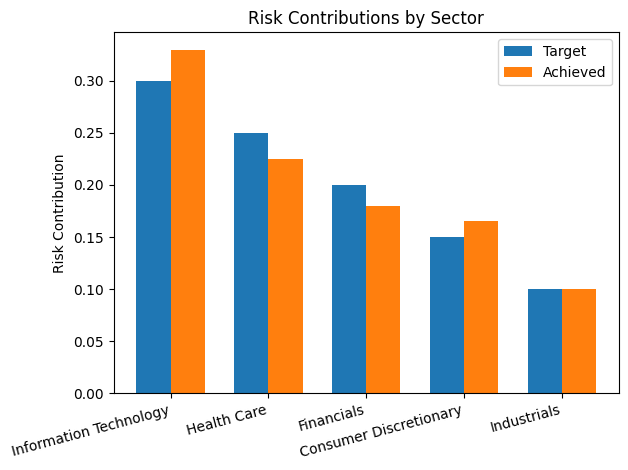

In [34]:
print("Target risk contributions:", b)
print("Risk contributions:", risk_contributions)

# plot risk contributions per sector
import matplotlib.pyplot as plt
sectors = ['Information Technology', 'Health Care', 'Financials', 
           'Consumer Discretionary', 'Industrials']
x = np.arange(len(sectors))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, b, width, label='Target')
rects2 = ax.bar(x + width/2, risk_contributions, width, label='Achieved')
ax.set_ylabel('Risk Contribution')
ax.set_title('Risk Contributions by Sector')
ax.set_xticks(x)
ax.set_xticklabels(sectors, rotation=15, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

Target risk contributions: [0.3  0.25 0.2  0.15 0.1 ]
Risk contributions: [0.32999995 0.22500008 0.18000005 0.16499994 0.09999998]


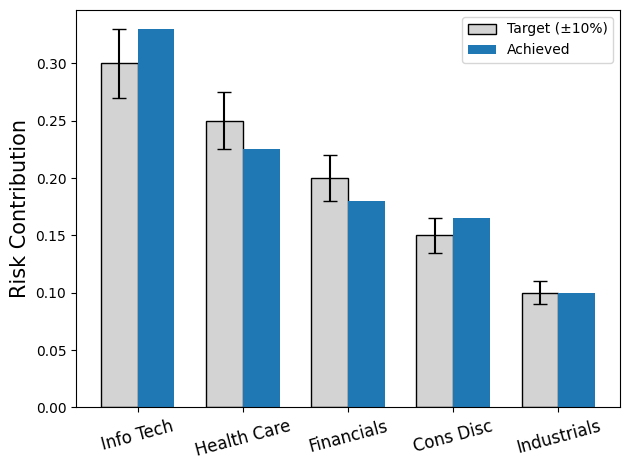

In [55]:
print("Target risk contributions:", b)
print("Risk contributions:", risk_contributions)

sectors = ['Info Tech', 'Health Care', 'Financials', 
           'Cons Disc', 'Industrials']
x = np.arange(len(sectors))
width = 0.35

# compute 10% tolerance
tolerance = 0.10 * np.array(b)

fig, ax = plt.subplots()
# add error bars to target bars
rects1 = ax.bar(x - width/2, b, width, yerr=tolerance, 
                label='Target (±10%)', capsize=5, color='lightgray', edgecolor='black')
rects2 = ax.bar(x + width/2, risk_contributions, width, label='Achieved', color='tab:blue')

ax.set_ylabel('Risk Contribution', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(sectors, rotation=15, ha='center', fontsize=12)
ax.legend()
plt.tight_layout()
plt.savefig("sector_risk_contributions.pdf")
